In [ ]:
import ast
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score

from LapBot.lapbot.src.data_transformation.data_cleaning.cleaning_utils import *

In [ ]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Thiết lập style mặc định cho matplotlib và seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Tùy chỉnh các tham số hiển thị
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.family"] = "Arial"

In [225]:
df = pd.read_csv('laptop_merged_v1_fix.csv')

In [226]:
detect_missing(df)

,Missing Values,Missing %
vga_vram,985,72.801183
cpu_threads,642,47.450111
cpu_speed,566,41.832964
cpu_max_speed,417,30.820399
refresh_rate,409,30.229120
root_price,353,26.090170
cpu_model,283,20.916482
discounted_price,260,19.216556
cpu_cores,160,11.825573
ram_speed,150,11.086475


**Tổng quan về các cột null**
- vga_vram null nhiều vì nhiều cột cần fill 0
- 13 cột là cột số
- 4 cột là text

**Dự kiến phương pháp thực hiện**
- Thực hiện từ các feature ít null đến feature null nhiều
- Sử dụng phương pháp fill 0 cho các cột cần fill 0
- Sử dụng rule-based cho các laptop hãng Apple
- Sử dụng gom nhóm, mode, mean
- Sử dụng các mô hình ML để predict các nhóm feature có độ tương quan cao

In [227]:
# Danh sách cột theo từng loại
binary = [
    "is_installment", "cam_ung"
]

continuous = [
    "discounted_price", "root_price", "cpu_speed", "cpu_max_speed", "battery_capacity",
    "ram_speed", "display_height", "display_width", "display_size",
    "product_weight", "width_mm", "height_mm", "depth_mm"
]

discrete = [
    "ram_storage", "storage_gb", "storage_max_support", "cpu_cores", "cpu_threads",
    "refresh_rate", "ram_slots",'vga_vram'
]

categorical = [
    "laptop_color", "cpu_brand", "cpu_series", "cpu_model", "vga_type",
    "vga_brand", "os_version", "manufacturer", "ram_type", "nhu_cau_su_dung",
    "material", "laptop_camera", "bluetooth_version"
]

metadata = [
    "image", "url_path", "product_id", "name"
]

column_groups = {
    "binary": binary,
    "continuous": continuous,
    "discrete": discrete,
    "categorical": categorical,
    "metadata": metadata
}

numeric = continuous + discrete
# In ra tổng kết số lượng cột mỗi nhóm
for group, cols in column_groups.items():
    print(f"{group.capitalize()} columns ({len(cols)}): {cols}")


Binary columns (2): ['is_installment', 'cam_ung']
Continuous columns (13): ['discounted_price', 'root_price', 'cpu_speed', 'cpu_max_speed', 'battery_capacity', 'ram_speed', 'display_height', 'display_width', 'display_size', 'product_weight', 'width_mm', 'height_mm', 'depth_mm']
Discrete columns (8): ['ram_storage', 'storage_gb', 'storage_max_support', 'cpu_cores', 'cpu_threads', 'refresh_rate', 'ram_slots', 'vga_vram']
Categorical columns (13): ['laptop_color', 'cpu_brand', 'cpu_series', 'cpu_model', 'vga_type', 'vga_brand', 'os_version', 'manufacturer', 'ram_type', 'nhu_cau_su_dung', 'material', 'laptop_camera', 'bluetooth_version']
Metadata columns (4): ['image', 'url_path', 'product_id', 'name']


In [228]:
def convert_list_string_column_to_text(df, column_name, separator=", "):
    """
    Chuyển các giá trị dạng list-string (ví dụ: "['a', 'b']") thành chuỗi phân tách (ví dụ: "a, b"),
    xử lý an toàn nếu lỗi cú pháp hoặc không đúng định dạng list.
    """
    def safe_convert(val):
        if pd.isna(val):
            return ''
        if isinstance(val, list):
            return separator.join(str(v).strip() for v in val)
        if isinstance(val, str):
            try:
                parsed = ast.literal_eval(val)
                if isinstance(parsed, list):
                    return separator.join(str(v).strip() for v in parsed)
                else:
                    return str(val)
            except Exception:
                # Nếu không parse được thì loại bỏ dấu [, ], ' và return raw string
                return val.replace("[", "").replace("]", "").replace("'", "").strip()
        return str(val)

    return df[column_name].apply(safe_convert)

In [229]:
df['nhu_cau_su_dung'] = convert_list_string_column_to_text(df, 'nhu_cau_su_dung')

In [230]:
# Danh sách các nhu cầu cần tách
tags = [
    "học tập - văn phòng", "laptop sáng tạo nội dung", "mỏng nhẹ",
    "gaming", "đồ họa - kỹ thuật", "cao cấp - sang trọng"
]

# Xử lý: Tạo cột nhị phân cho từng tag
for tag in tags:
    df[tag] = df["nhu_cau_su_dung"].apply(lambda x: int(tag in x))

In [ ]:
def normalize_column(col):
    """
    Chuẩn hóa tên cột thành định dạng chuẩn để xử lý dữ liệu.

    Các bước chuẩn hóa bao gồm:
    1. Loại bỏ ký tự xuống dòng (`\n`).
    2. Loại bỏ dấu ":" nếu xuất hiện ở cuối chuỗi.
    3. Loại bỏ dấu tiếng Việt (chuyển về ASCII).
    4. Chuyển toàn bộ chuỗi về chữ thường.
    5. Thay thế tất cả ký tự không phải chữ cái, số hoặc "_" bằng "_".
    6. Loại bỏ dấu "_" ở đầu và cuối chuỗi nếu có.

    Args:
        col (str): Tên cột cần chuẩn hóa.

    Returns:
        str: Tên cột đã được chuẩn hóa.
    """
    col = col.replace('\n', ' ')
    col = col.rstrip(':')
    col = unidecode.unidecode(col)
    col = col.lower()
    col = re.sub(r'\W+', '_', col)
    col = col.strip('_')
    return col

In [232]:
df.columns = [normalize_column(col) for col in df.columns]
df.columns = list(map(normalize_column, df.columns))

In [ ]:
def plot_distribution_with_labels(before_series, after_series, name_col):
    """Vẽ biểu đồ phân bố của một cột trước và sau khi điền giá trị thiếu."""

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"Phân bố '{name_col}' TRƯỚC và SAU khi điền", fontsize=14)

    settings = [
        (before_series, "TRƯỚC khi điền", "skyblue", axes[0]),
        (after_series, "SAU khi điền", "lightgreen", axes[1])
    ]

    for series, title, color, ax in settings:
        series_clean = series.dropna()
        num_unique = series_clean.nunique()

        if num_unique <= 10:
            # Vẽ biểu đồ cột nếu giá trị unique ít
            value_counts = series_clean.value_counts().sort_index()
            sns.barplot(
                x=value_counts.index.astype(str),
                y=value_counts.values,
                ax=ax,
                color=color
            )
            for j, value in enumerate(value_counts.values):
                ax.text(
                    j,
                    value + 0.5,
                    str(int(value)),
                    ha="center",
                    va="bottom",
                    fontsize=10
                )
        else:
            # Vẽ histogram nếu có nhiều giá trị unique
            sns.histplot(series_clean, kde=False, bins=30, ax=ax, color=color)
            ax.set_ylabel("Tần suất")

        ax.set_title(title)
        ax.set_xlabel(name_col)
        ax.tick_params(axis="x", rotation=30)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
def show_top_frequencies(before_series, after_series, name_col, top_n=30):
    """
    Hiển thị tần suất xuất hiện phổ biến nhất (top N) trước và sau khi xử lý một cột.

    Parameters:
    - before_series: Series gốc trước khi xử lý (pandas Series)
    - after_series: Series sau khi xử lý
    - name_col: Tên cột cần hiển thị (string)
    - top_n: Số lượng giá trị phổ biến nhất cần hiển thị (int, mặc định = 30)
    """
    before_counts = before_series.value_counts().head(top_n)
    after_counts = after_series.value_counts().head(top_n)

    freq_df = pd.DataFrame({
        f"Top {top_n} TRƯỚC khi điền": before_counts,
        f"Top {top_n} SAU khi điền": after_counts
    }).fillna(0).astype(int)

    print(f"Tần suất phổ biến nhất của '{name_col}':")
    display(freq_df)


**1.1 vga_type**

Dựa vào cột cpu_model, vga_brand để phân biệt vga_type

In [235]:
vga_type_before = df['vga_type'].copy()

In [236]:
df[(df['vga_type'] == 'card tích hợp') & (df['vga_brand'] == 'amd')]['cpu_model'].head()

26     7520u
36     5700u
64     5700u
72     5700u
106    7520u
Name: cpu_model, dtype: object

In [237]:
df[(df['vga_type'] == 'card rời') & (df['vga_brand'] == 'intel')]['cpu_model']

746             1215u
816            13620h
876     226v series 2
974            1035g1
1245             185h
Name: cpu_model, dtype: object

In [238]:
intel_dedicated_cpu_models = [
    '185h', '1035g1', '226v series 2', '13620h', '1215u'
]

amd_integrated_cpu_models = list(set([
    '7520u', '5700u', '7530u', '8840hs', '7430u', '8640hs',
    'hx 370', '7730u', '365', '8640u', '8845hs', '350',
    '7735hs', '5625u', '4500u', '5600h'
]))

def normalize_cpu(cpu):
    """
    Chuẩn hóa tên CPU: chuyển về chữ thường, loại bỏ khoảng trắng, xử lý NaN.

    Args:
        cpu (str or any): Tên CPU hoặc giá trị thiếu.

    Returns:
        str: Chuỗi đã chuẩn hóa hoặc rỗng nếu thiếu.
    """
    if pd.isna(cpu):
        return ''
    return str(cpu).strip().lower()

def fill_vga_type(row):
    """
    Suy đoán loại card đồ họa ('card rời' hoặc 'card tích hợp') từ vga_brand và cpu_model.

    Args:
        row (pd.Series): Dòng dữ liệu chứa 'vga_type', 'vga_brand', 'cpu_model'.

    Returns:
        str: Giá trị 'vga_type' đã suy đoán hoặc giữ nguyên nếu đã có.
    """
    if pd.notna(row['vga_type']):
        return row['vga_type']
    
    brand = str(row['vga_brand']).strip().lower()
    cpu = normalize_cpu(row['cpu_model'])

    if brand == 'nvidia':
        return 'card rời'
    elif brand == 'apple':
        return 'card tích hợp'
    elif brand == 'intel':
        if any(model.lower() in cpu for model in intel_dedicated_cpu_models):
            return 'card rời'
        else:
            return 'card tích hợp'
    elif brand == 'amd':
        if any(model in cpu for model in amd_integrated_cpu_models):
            return 'card tích hợp'
        else:
            return 'card rời'
    else:
        return 'card tích hợp'


In [239]:
df['vga_type'] = df.apply(fill_vga_type, axis=1)


In [240]:
df.loc[df['manufacturer'] == 'apple', 'vga_type'] = 'card tích hợp'

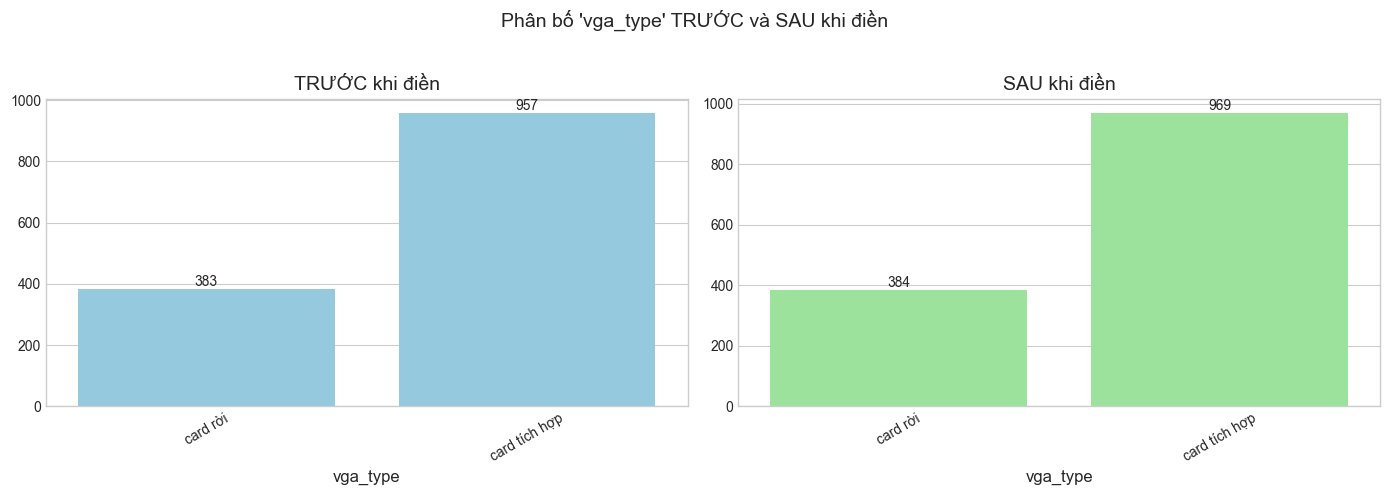

In [241]:
plot_distribution_with_labels(vga_type_before, df['vga_type'], 'vga_type')

**1.2 laptop_camera**

Gom nhóm dựa vào manufacturer để dùng mode fill cho laptop_camera

In [242]:
laptop_camera_before = df['laptop_camera'].copy()

In [243]:
df[['laptop_camera', 'manufacturer']].head()

,laptop_camera,manufacturer
0,full hd,asus
1,hd,lenovo
2,hd,acer
3,hd,asus
4,hd,apple


In [244]:
# Điền giá trị thiếu bằng mode trong từng hãng
df['laptop_camera'] = df.groupby('manufacturer')['laptop_camera'].transform(
    lambda x: x.fillna(
        x.mode()[0] if not x.mode().empty else df['laptop_camera'].mode()[0]
    )
)

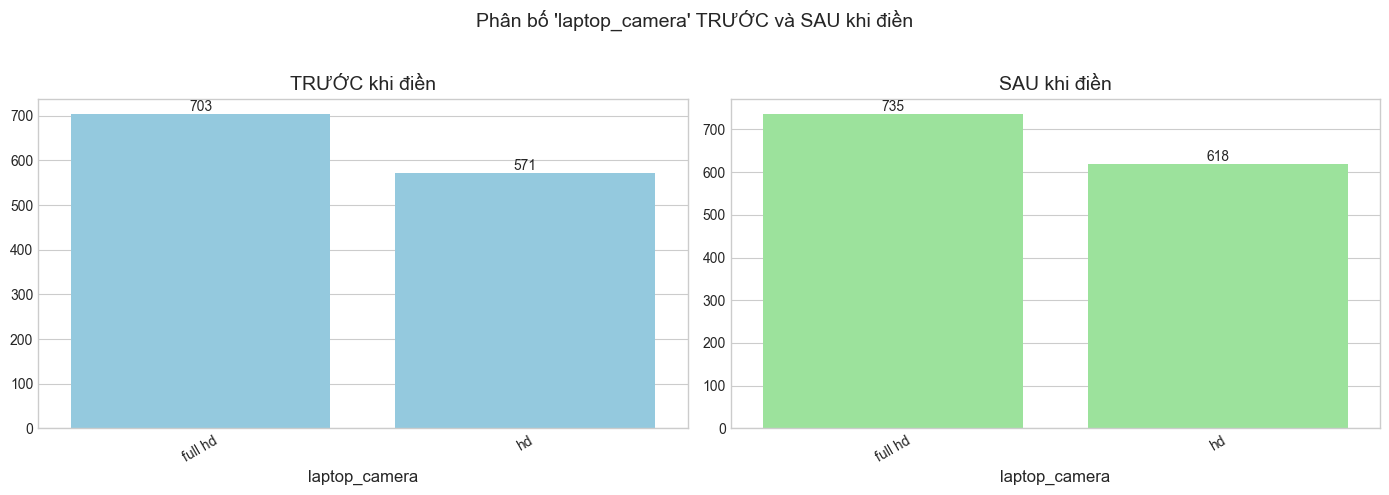

In [245]:
plot_distribution_with_labels(laptop_camera_before, df['laptop_camera'], 'laptop_camera')

**1.3 width_mm và height_mm**

Tính trung bình width_mm và height_mm theo từng kích thước màn hình (display_size)

In [246]:
height_mm_before = df['height_mm'].copy()
width_mm_before = df['width_mm'].copy()

In [247]:
df[['height_mm', 'depth_mm','width_mm', 'display_size', 'product_weight','mong_nhe', 'gaming']].head()

,height_mm,depth_mm,width_mm,display_size,product_weight,mong_nhe,gaming
0,227.0,19.90,311.0,14.0,1.46,0,1
1,235.0,17.90,359.3,15.6,1.62,0,1
2,237.5,17.99,362.9,15.6,1.70,0,0
3,232.5,17.90,359.7,15.6,1.70,0,1
4,212.4,4.10,304.1,13.3,1.29,1,0


In [248]:
avg_dims = df[df[['width_mm', 'height_mm']].notnull().all(axis=1)].groupby('display_size')[
    ['width_mm', 'height_mm']
].mean()

def fill_missing_by_display_size(row, col):
    """
    Điền giá trị thiếu cho cột 'col' (width_mm hoặc height_mm) dựa theo giá trị trung bình
    của cùng 'display_size'.

    Args:
        row (pd.Series): Một dòng dữ liệu chứa display_size và cột cần điền.
        col (str): Tên cột cần điền giá trị ('width_mm' hoặc 'height_mm').

    Returns:
        float: Giá trị gốc nếu không thiếu, hoặc giá trị trung bình theo display_size nếu có.
    """
    if pd.isna(row[col]):
        display_size = row['display_size']
        if display_size in avg_dims.index:
            return avg_dims.loc[display_size, col]
    return row[col]

for col in ['width_mm', 'height_mm']:
    df[col] = df.apply(lambda row: fill_missing_by_display_size(row, col), axis=1)


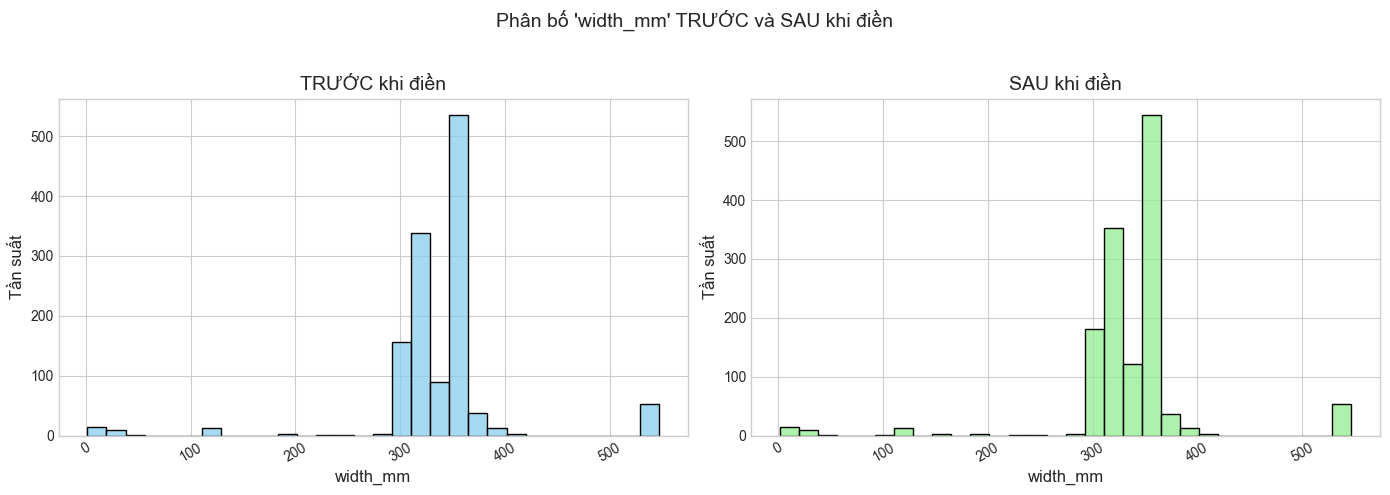

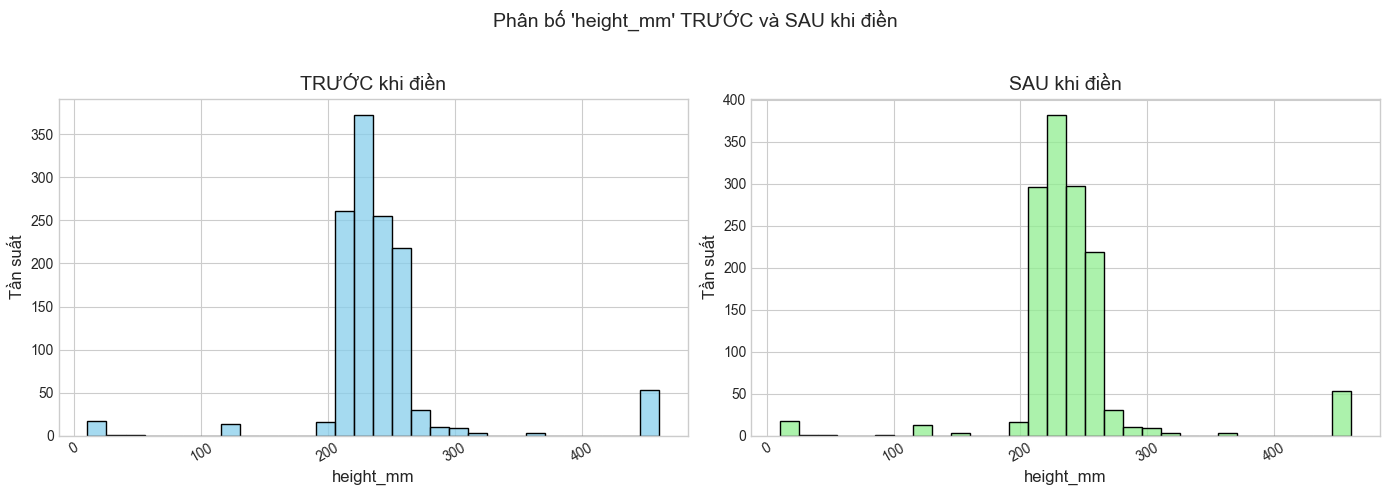

In [249]:
plot_distribution_with_labels(width_mm_before, df['width_mm'], 'width_mm')
plot_distribution_with_labels(height_mm_before, df['height_mm'], 'height_mm')

**1.4 depth_mm**

Tính giá trị trung bình theo nhóm nhu cầu mỏng nhẹ hoặc gamming

In [250]:
depth_mm_before = df['depth_mm'].copy()

In [251]:
# 1. Lọc các dòng có giá trị depth_mm không bị thiếu
df_height = df[df['depth_mm'].notna()].copy()

def classify(row):
    """
    Phân loại nhu cầu sử dụng dựa vào nhãn 'mong_nhe' và 'gaming'.

    Returns:
        str: Một trong các nhóm: 'mong_nhe', 'gaming', 'cả hai', 'khác'.
    """
    if row['mong_nhe'] == 1 and row['gaming'] == 0:
        return 'mong_nhe'
    elif row['mong_nhe'] == 0 and row['gaming'] == 1:
        return 'gaming'
    elif row['mong_nhe'] == 1 and row['gaming'] == 1:
        return 'cả hai'
    else:
        return 'khác'

# Gán nhãn nhóm nhu cầu vào cột mới
df_height['nhom_nhu_cau'] = df_height.apply(classify, axis=1)

# Tính trung bình độ dày (depth_mm) cho từng nhóm nhu cầu
mean_height_by_group = df_height.groupby('nhom_nhu_cau')['depth_mm'].mean()

def fill_height_by_nhu_cau(row):
    """
    Điền giá trị thiếu cho 'depth_mm' dựa vào trung bình nhóm nhu cầu.

    Args:
        row (pd.Series): Một dòng dữ liệu với các cột 'mong_nhe', 'gaming', 'depth_mm'.

    Returns:
        float: Giá trị gốc nếu không thiếu, hoặc giá trị trung bình theo nhóm nhu cầu.
    """
    if pd.isna(row['depth_mm']):
        if row['mong_nhe'] == 1 and row['gaming'] == 0:
            return mean_height_by_group.get('mong_nhe', np.nan)
        elif row['mong_nhe'] == 0 and row['gaming'] == 1:
            return mean_height_by_group.get('gaming', np.nan)
        elif row['mong_nhe'] == 1 and row['gaming'] == 1:
            return mean_height_by_group.get('cả hai', np.nan)
        else:
            return mean_height_by_group.get('khác', np.nan)
    return row['depth_mm']

df['depth_mm'] = df.apply(fill_height_by_nhu_cau, axis=1)


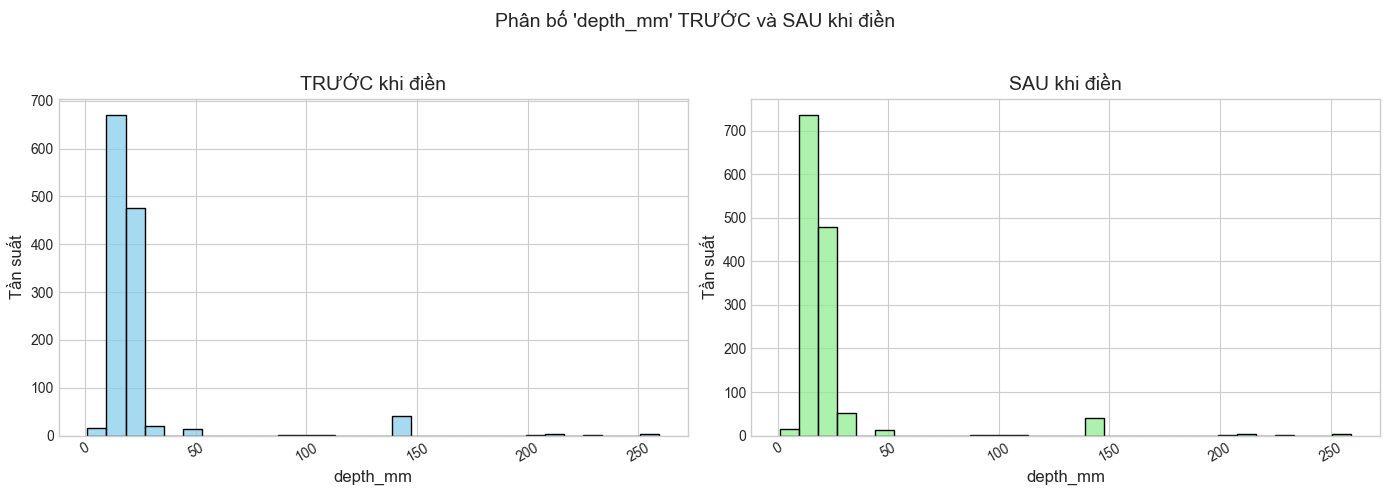

In [252]:
plot_distribution_with_labels(depth_mm_before, df['depth_mm'], 'depth_mm')

**1.5 cpu_model**

- Fill theo hãng Apple: extract thông tin từ tên của laptop
- Fill mannual 3 laptop khác hãng apple

In [253]:
df['cpu_model'] = df['cpu_model'].astype('object')

In [254]:
cpu_model_before = df['cpu_model'].copy()

In [255]:
df[(df['cpu_model'].isna()) & (df['manufacturer'] != 'apple')]

,cam_ung,height_mm,url_path,material,storage_max_support,storage_gb,display_width,bluetooth_version,width_mm,manufacturer,cpu_max_speed,root_price,cpu_threads,cpu_cores,ram_speed,product_weight,discounted_price,ram_type,refresh_rate,cpu_speed,name,ram_storage,is_installment,ram_slots,os_version,battery_capacity,laptop_color,cpu_model,nhu_cau_su_dung,vga_type,depth_mm,image,vga_brand,product_id,cpu_series,display_height,vga_vram,laptop_camera,display_size,cpu_brand,hoc_tap_van_phong,laptop_sang_tao_noi_dung,mong_nhe,gaming,do_hoa_ky_thuat,cao_cap_sang_trong
847,0,229.9,https://cellphones.com.vnlaptop-huawei-mateboo...,vỏ kim loại,512.0,512.0,1920.0,5.1,357.8,huawei,NaN,13990000.0,NaN,NaN,NaN,1.63,10660000.0,ddr4,NaN,NaN,Laptop Huawei Matebook D15,8.0,0,NaN,windows 11,42.0,đen,NaN,"học tập - văn phòng, mỏng nhẹ",card tích hợp,16.9,/t/e/text_ng_n_13__3_29.png,amd,65177.0,ryzen 7,1080.0,NaN,hd,15.6,amd,1,0,1,0,0,0
997,0,220.1,https://cellphones.com.vn/laptop-asus-zenbook-...,vỏ kim loại,512.0,512.0,2880.0,5.3,312.4,asus,4.5,28990000.0,18.0,14.0,NaN,1.20,25590000.0,lpddr5x,120.0,1.2,Laptop ASUS Zenbook 14 OLED UX3405MA-PP588W-Bạc,16.0,0,0.0,windows 11,75.0,bạc,NaN,"học tập - văn phòng, cao cấp - sang trọng, mỏn...",card tích hợp,14.9,https://cdn2.cellphones.com.vn/insecure/rs:fil...,intel,75614.0,core ultra 5,1800.0,NaN,full hd,14.0,intel,1,1,1,0,0,1
1113,0,307.5,https://cellphones.com.vn/laptop-msi-titan-18-...,vỏ kim loại,6144.0,6144.0,3840.0,5.4,404.0,msi,5.5,174990000.0,24.0,24.0,6400.0,3.60,174590000.0,ddr5,120.0,2.8,Laptop MSI Titan 18 HX AI A2XWJG-622VN-Đen,64.0,0,2.0,windows 11,99.9,đen,NaN,"đồ họa - kỹ thuật, gaming",card rời,24.0,https://cdn2.cellphones.com.vn/insecure/rs:fil...,nvidia,103107.0,core ultra 9,2400.0,24.0,full hd,18.0,intel,0,0,0,1,1,0


In [256]:
name_to_cpu_model = {
    "Laptop Huawei Matebook D15": "ddr4",
    "Laptop ASUS Zenbook 14 OLED UX3405MA-PP588W-Bạc": "lpddr5x",
    "Laptop MSI Titan 18 HX AI A2XWJG-622VN-Đen": "ddr4"
}

In [257]:
df["cpu_model"] = df.apply(
    lambda row: name_to_cpu_model.get(row["name"], row["cpu_model"]) if pd.isna(row["cpu_model"]) else row["cpu_model"],
    axis=1
)

In [258]:
df["cpu_model"] = df["cpu_model"].replace("hãng không công bố", np.nan)

In [259]:
def extract_apple_cpu_model(name: str) -> str | None:
    """
    Trích xuất model CPU Apple (ví dụ: 'm1', 'm2 pro', 'm3 max', 'm4 ultra') từ tên sản phẩm.

    Args:
        name (str): Tên sản phẩm chứa thông tin về CPU.

    Returns:
        str | None: Tên model CPU nếu tìm được, ngược lại trả về None.
    """
    name_lower = name.lower()

    # 1. Ưu tiên tìm các cụm rõ ràng: m1 pro, m2 max, m3 ultra,...
    match = re.search(r'\bm([1-9])\s*(pro|max|ultra)\b', name_lower)
    if match:
        return f"m{match.group(1)} {match.group(2)}"

    # 2. Tìm m[1-9] đơn thuần
    base_match = re.search(r'\bm([1-9])\b', name_lower)
    if base_match:
        base = f"m{base_match.group(1)}"

        # Nếu là MacBook Pro → mặc định suffix là 'pro'
        if "macbook pro" in name_lower:
            return f"{base} pro"

        # Nếu là MacBook Air → giữ nguyên
        if "macbook air" in name_lower or "air" in name_lower:
            return base

        return base

    # 3. Trường hợp đặc biệt: MacBook Pro 2021 không ghi rõ model
    if "macbook pro" in name_lower and "2021" in name_lower:
        return "m1 max" if "max" in name_lower else "m1 pro"

    return None


In [260]:
# Chỉ định điều kiện lọc
mask = (df['cpu_model'].isna()) & (df['manufacturer'].str.lower() == 'apple')

# Cập nhật giá trị mới bằng apply
df.loc[mask, 'cpu_model'] = df.loc[mask, 'name'].apply(extract_apple_cpu_model)

In [261]:
df["cpu_model"] = df["cpu_model"].str.replace(r"\bapple\b", "", regex=True).str.strip()

In [262]:
df.loc[df['name'].str.contains('MacBook Pro 14 M4 Max', case=False, na=False), 'cpu_model'] = 'm4 max'


In [263]:
show_top_frequencies(cpu_model_before, df['cpu_model'], 'cpu_model')

Tần suất phổ biến nhất của 'cpu_model':


,Top 30 TRƯỚC khi điền,Top 30 SAU khi điền
cpu_model,,
1135g7,11,11
120u,10,0
1215u,18,18
1235u,54,54
12450h,32,32
12450hx,16,16
12500h,22,22
1255u,18,18
125h,27,27


**1.6 ram_type**

Toàn bộ null đều thuộc hãng Apple và dùng rule-base để mapping

In [264]:
ram_type_before = df['ram_type'].copy()

In [265]:
cpu_to_ram_type = {
    "m1": "lpddr4x",
    "m2": "lpddr5",
    "m3": "lpddr5",
    "m4": "lpddr5x",
    "m4 pro": "lpddr5",
    "m4 max" : "lpddr5x"
}

In [266]:
df["ram_type"] = df["ram_type"].fillna(
    df["cpu_model"].map(cpu_to_ram_type)
)

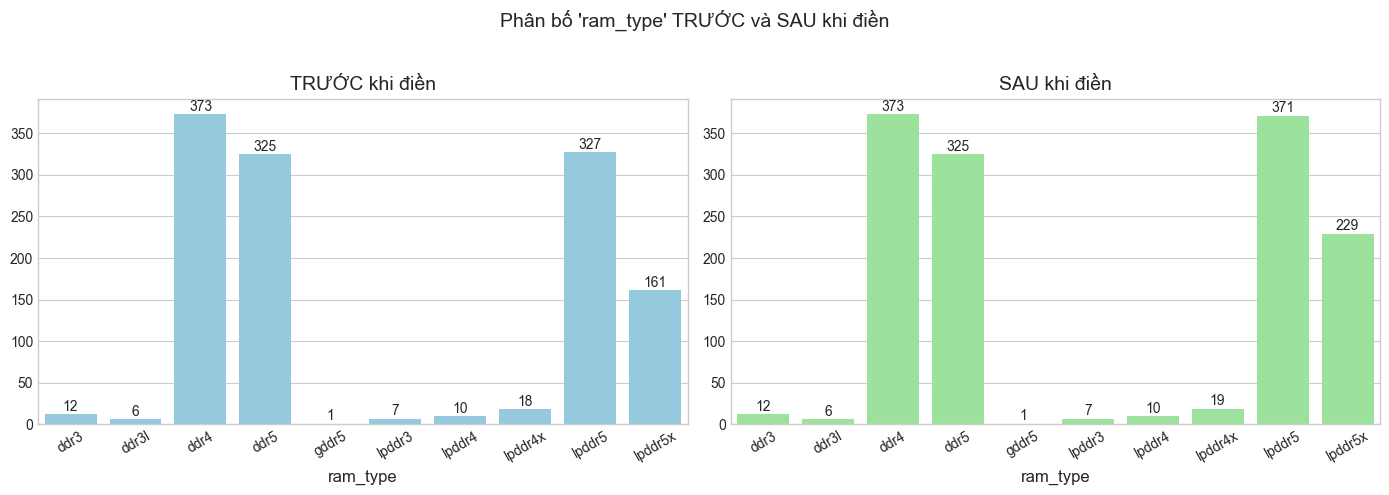

In [267]:
plot_distribution_with_labels(ram_type_before, df['ram_type'], 'ram_type')

**1.7 ram_slots**

Dựa vào name và display_size để lập rule cho ram_slots

In [268]:
ram_slots_before = df['ram_slots'].copy()

In [ ]:
def estimate_ram_slots(row):
    """
    Ước lượng số khe RAM dựa trên tên sản phẩm, loại RAM và kích thước màn hình.

    Tham số:
        row (Series): Một dòng dữ liệu với các cột 'name', 'ram_type', 'display_size'.

    Trả về:
        int: Số khe RAM ước lượng.
    """
    name = str(row["name"]).lower()
    ram_type = str(row["ram_type"]).lower()
    display_size = row.get("display_size", 0)

    if any(keyword in name for keyword in ["gaming", "tuf", "vivobook", "swift lite"]):
        return 2
    elif "macbook" in name or "lpddr" in ram_type or "zenbook" in name or "swift" in name:
        return 0
    elif display_size >= 15.6:
        return 2
    else:
        return 1


In [ ]:
# Lọc những dòng thiếu thông tin về số khe RAM
mask_missing_slots = df["ram_slots"].isna()

# Áp dụng hàm ước lượng cho các dòng này
df.loc[mask_missing_slots, "ram_slots"] = df.loc[mask_missing_slots].apply(
    estimate_ram_slots,
    axis=1
)

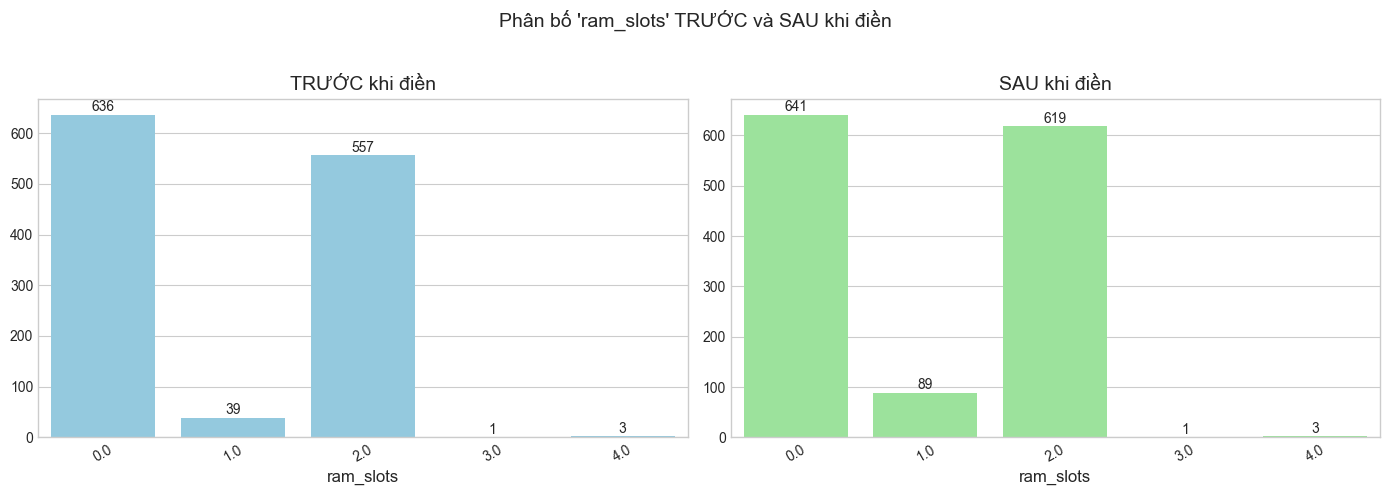

In [271]:
plot_distribution_with_labels(ram_slots_before, df['ram_slots'], 'ram_slots')

In [272]:
df.to_csv('laptop_merge_v2.csv', index=False)

In [273]:
cpu_cores_before = df['cpu_cores'].copy()
cpu_threads_before = df['cpu_threads'].copy()

**1.8 cpu_cores và cpu_threads**

Dùng model RandomForest và XGBoost so sánh với nhau, chọn tham số tối ưu và predict cpu_cores và cpu_threads dựa trên các cột không null ( tại file predict_cpu_cores_threads.ipynb)
- binary_columns = [
    'hoc_tap_van_phong', 'laptop_sang_tao_noi_dung', 'mong_nhe',
    'gaming', 'do_hoa_ky_thuat', 'cao_cap_sang_trong',
    'is_i3', 'is_i5', 'is_i7', 'is_i9', 'is_ryzen_3', 'is_ryzen_5',
    'is_ryzen_7', 'is_ryzen_9', 'is_apple_m', 'is_snapdragon', 'is_celeron', 'is_pentium'
]
- cat_columns = ['cpu_model', 'cpu_series', 'cpu_brand']
- num_columns = [col for col in ['ram_storage', 'display_size']

In [274]:
df = pd.read_csv('laptop_merge_v3.csv')

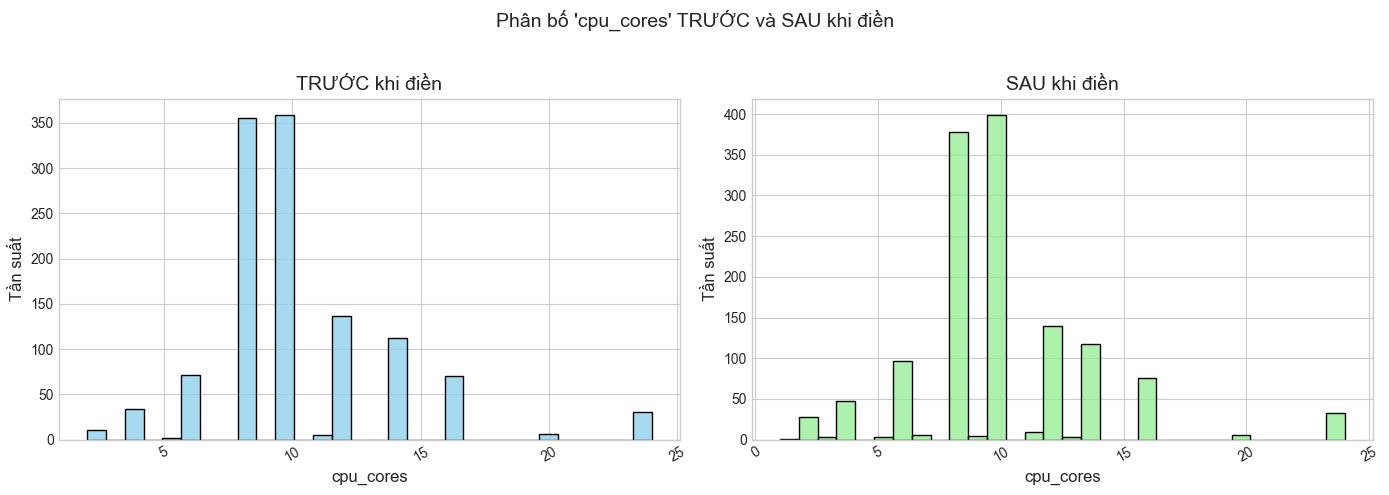

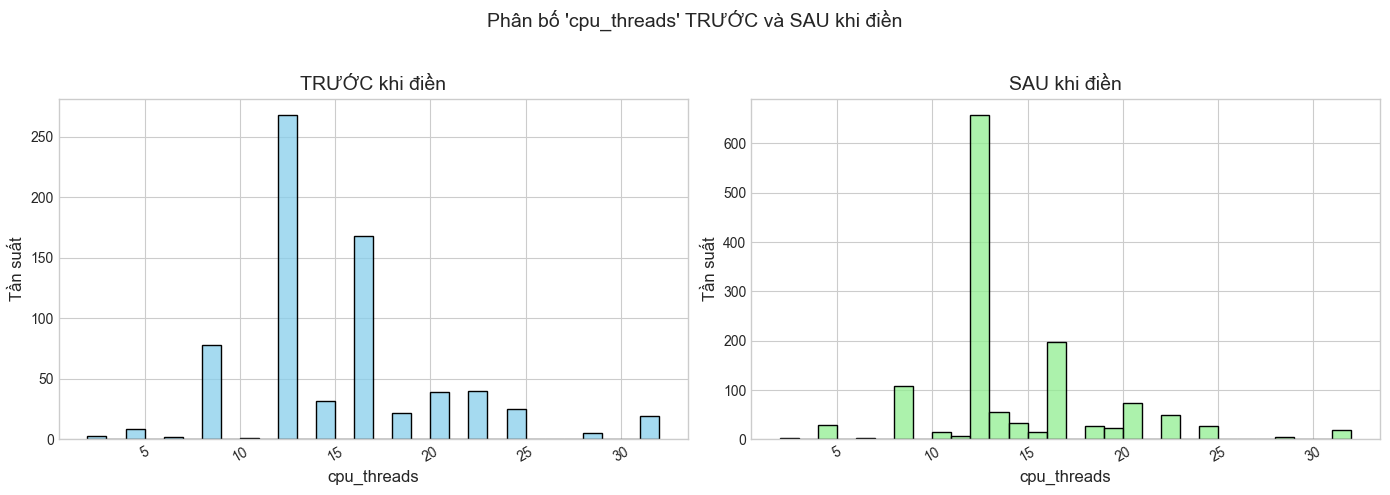

In [275]:
plot_distribution_with_labels(cpu_cores_before, df['cpu_cores'],'cpu_cores')
plot_distribution_with_labels(cpu_threads_before, df['cpu_threads'], 'cpu_threads')

**1.9 cpu_speed và cpu_max_speed**

Dùng rule-based cho các dòng Macbook sau đó dùng model để predict

In [276]:

cpu_max_speed_before = df['cpu_max_speed'].copy()

In [277]:
df.loc[df['manufacturer'].str.lower() == 'apple', ['cpu_speed', 'cpu_max_speed']] = None

In [278]:
df[(df['cpu_speed'].isna()) & (df['cpu_max_speed'].isna()) & (df['manufacturer'] == 'apple')].head()

,cam_ung,height_mm,url_path,material,storage_max_support,storage_gb,display_width,bluetooth_version,width_mm,manufacturer,cpu_max_speed,root_price,cpu_threads,cpu_cores,ram_speed,product_weight,discounted_price,ram_type,refresh_rate,cpu_speed,name,ram_storage,is_installment,ram_slots,os_version,battery_capacity,laptop_color,cpu_model,nhu_cau_su_dung,vga_type,depth_mm,image,vga_brand,product_id,cpu_series,display_height,vga_vram,laptop_camera,display_size,cpu_brand,hoc_tap_van_phong,laptop_sang_tao_noi_dung,mong_nhe,gaming,do_hoa_ky_thuat,cao_cap_sang_trong
4,0,212.4,https://www.thegioididong.com/laptop/apple-mac...,vỏ kim loại,256.0,256.0,2560.0,5.0,304.1,apple,NaN,19990000.0,12.0,8.0,4266.0,1.29,17190000.0,lpddr4x,60.0,NaN,Laptop MacBook Air 13 inch M1 8GB/256GB (MGN63...,8.0,1,0.0,macos,NaN,xám,m1,"cao cấp - sang trọng, học tập - văn phòng, lap...",card tích hợp,4.1,https://cdn.tgdd.vn/Products/Images/44/231244/...,apple,0220042001279__l4_20250402-105034,m1,1600.0,NaN,hd,13.3,apple,1,1,1,0,1,1
55,0,215.0,https://www.thegioididong.com/laptop/apple-mac...,vỏ kim loại,256.0,256.0,2560.0,5.3,304.1,apple,NaN,29990000.0,12.0,8.0,6400.0,1.24,23090000.0,lpddr5,60.0,NaN,Laptop Apple MacBook Air 13 inch M2 16GB/256GB...,16.0,1,0.0,macos,NaN,xám,m2,"học tập - văn phòng, cao cấp - sang trọng, mỏn...",card tích hợp,11.3,https://cdn.tgdd.vn/Products/Images/44/325306/...,apple,0220042002497__l101_20250402-105034,m2,1664.0,NaN,full hd,13.6,apple,1,0,1,0,0,1
56,0,215.0,https://www.thegioididong.com/laptop/apple-mac...,vỏ kim loại,256.0,256.0,2560.0,5.3,304.1,apple,NaN,29990000.0,12.0,8.0,6400.0,1.24,23090000.0,lpddr5,60.0,NaN,Laptop Apple MacBook Air 13 inch M2 16GB/256GB...,16.0,1,0.0,macos,NaN,bạc,m2,"học tập - văn phòng, cao cấp - sang trọng, mỏn...",card tích hợp,11.3,https://cdn.tgdd.vn/Products/Images/44/325306/...,apple,0220042002498__l101_20250402-105034,m2,1664.0,NaN,full hd,13.6,apple,1,0,1,0,0,1
57,0,215.0,https://www.thegioididong.com/laptop/apple-mac...,vỏ kim loại,256.0,256.0,2560.0,5.3,304.1,apple,NaN,29990000.0,12.0,8.0,6400.0,1.24,23090000.0,lpddr5,60.0,NaN,Laptop Apple MacBook Air 13 inch M2 16GB/256GB...,16.0,1,0.0,macos,NaN,xanh dương,m2,"học tập - văn phòng, cao cấp - sang trọng, mỏn...",card tích hợp,11.3,https://cdn.tgdd.vn/Products/Images/44/325306/...,apple,0220042002500__l101_20250402-105034,m2,1664.0,NaN,full hd,13.6,apple,1,0,1,0,0,1
76,0,215.0,https://www.thegioididong.com/laptop/macbook-a...,vỏ kim loại,512.0,512.0,2560.0,5.3,304.1,apple,NaN,32990000.0,12.0,8.0,6400.0,1.24,28690000.0,lpddr5,60.0,NaN,Laptop MacBook Air 13 inch M3 16GB/512GB (MXCU...,16.0,1,0.0,macos,NaN,vàng,m3,"cao cấp - sang trọng, gaming, học tập - văn ph...",card tích hợp,11.3,https://cdn.tgdd.vn/Products/Images/44/322634/...,apple,0220042002599__l51_20250402-105034,m3,1664.0,NaN,full hd,13.6,apple,1,1,1,1,1,1


In [279]:
macbook_cpu_specs = {
    'm1': {'cpu_model': 'm1', 'cpu_speed': 3.2, 'cpu_max_speed': 3.2},  
    'm1 pro': {'cpu_model': 'm1 pro', 'cpu_speed': 3.2, 'cpu_max_speed': 3.2},
    'm1 max': {'cpu_model': 'm1 max', 'cpu_speed': 3.2, 'cpu_max_speed': 3.2},
    'm2': {'cpu_model': 'm2', 'cpu_speed': 3.49, 'cpu_max_speed': 3.49},
    'm2 pro': {'cpu_model': 'm2 pro', 'cpu_speed': 3.5, 'cpu_max_speed': 3.5},
    'm2 max': {'cpu_model': 'm2 max', 'cpu_speed': 3.68, 'cpu_max_speed': 3.68},
    'm2 ultra': {'cpu_model': 'm2 ultra', 'cpu_speed': 3.5, 'cpu_max_speed': 3.5},
    'm3': {'cpu_model': 'm3', 'cpu_speed': 3.7, 'cpu_max_speed': 3.7},
    'm3 pro': {'cpu_model': 'm3 pro', 'cpu_speed': 3.7, 'cpu_max_speed': 3.7},
    'm3 max': {'cpu_model': 'm3 max', 'cpu_speed': 3.7, 'cpu_max_speed': 3.7},
    'm4': {'cpu_model': 'm4', 'cpu_speed': 4.0, 'cpu_max_speed': 4.0}, 
    'm4 pro': {'cpu_model': 'm4 pro', 'cpu_speed': 4.2, 'cpu_max_speed': 4.2},  
    'm4 max': {'cpu_model': 'm4 max', 'cpu_speed': 4.4, 'cpu_max_speed': 4.4},
    '8500b' : {'cpu_model': '8500b', 'cpu_speed': 1.4, 'cpu_max_speed': 4.5}
}

In [ ]:
def fill_macbook_cpu(row):
    """
    Điền thông tin tốc độ CPU cho các dòng MacBook dựa trên model.

    Parameters:
        row (Series): Một dòng dữ liệu.

    Returns:
        Series: Dòng dữ liệu sau khi có thể đã được cập nhật.
    """
    if str(row["manufacturer"]).lower() != "apple":
        return row

    model_key = str(row.get("cpu_model", "")).strip()

    if model_key in macbook_cpu_specs:
        specs = macbook_cpu_specs[model_key]
        row["cpu_speed"] = specs.get("cpu_speed", np.nan)
        row["cpu_max_speed"] = specs.get("cpu_max_speed", np.nan)

    return row

In [281]:
df = df.apply(fill_macbook_cpu, axis=1)

In [282]:
df_before = pd.read_csv('laptop_merge_v2.csv')

In [283]:
df_before[(df_before['cpu_cores'].isna()) & (df_before['cpu_max_speed'].isna()) & (df_before['manufacturer'] != 'apple')].head()

,cam_ung,height_mm,url_path,material,storage_max_support,storage_gb,display_width,bluetooth_version,width_mm,manufacturer,cpu_max_speed,root_price,cpu_threads,cpu_cores,ram_speed,product_weight,discounted_price,ram_type,refresh_rate,cpu_speed,name,ram_storage,is_installment,ram_slots,os_version,battery_capacity,laptop_color,cpu_model,nhu_cau_su_dung,vga_type,depth_mm,image,vga_brand,product_id,cpu_series,display_height,vga_vram,laptop_camera,display_size,cpu_brand,hoc_tap_van_phong,laptop_sang_tao_noi_dung,mong_nhe,gaming,do_hoa_ky_thuat,cao_cap_sang_trong
478,0,258.0,https://cellphones.com.vnlaptop-gigabyte-g5-md...,vỏ nhựa,512.0,512.0,1920.0,5.2,361.0,gigabyte,NaN,NaN,NaN,NaN,3200.0,2.20,NaN,ddr4,144.0,NaN,Laptop Gigabyte G5 MD-51S1123SH,16.0,0,2.0,windows 11,48.96,đen,11400h,gaming,card rời,24.9,/2/_/2_76.jpg,nvidia,51426.0,core i5,1080.0,4.0,hd,15.6,intel,0,0,0,1,0,0
507,0,259.0,https://cellphones.com.vn/laptop-msi-katana-15...,vỏ nhựa,1024.0,512.0,1920.0,5.3,359.0,msi,NaN,28990000.0,NaN,NaN,5200.0,2.25,24590000.0,ddr5,144.0,NaN,Laptop MSI Katana 15 B13VEK-2256VN-Đen,16.0,0,2.0,windows 11,53.50,đen,13620h,"đồ họa - kỹ thuật, gaming",card rời,24.9,https://cdn2.cellphones.com.vn/insecure/rs:fil...,nvidia,94522.0,core i7,1080.0,6.0,hd,15.6,intel,0,0,0,1,1,0
511,0,208.0,https://cellphones.com.vnlaptop-asus-zenbook-u...,vỏ kim loại,512.0,512.0,1920.0,5.0,319.0,asus,NaN,NaN,NaN,NaN,NaN,1.17,NaN,lpddr4x,60.0,NaN,Laptop ASUS Zenbook UX425EA BM069T,8.0,0,0.0,windows 10,NaN,đen,1135g7,"học tập - văn phòng, mỏng nhẹ",card tích hợp,13.9,/1/3/13_5_24_2.jpg,intel,45094.0,core i5,1080.0,NaN,hd,14.0,intel,1,0,1,0,0,0
513,0,220.1,https://cellphones.com.vn/laptop-asus-zenbook-...,vỏ kim loại,1024.0,1024.0,2880.0,5.3,312.4,asus,NaN,34990000.0,NaN,NaN,NaN,1.20,30990000.0,lpddr5x,120.0,NaN,Laptop ASUS Zenbook 14 OLED UX3405MA-PP152W-Xa...,32.0,0,0.0,windows 11,75.00,xanh dương,155h,"học tập - văn phòng, cao cấp - sang trọng, mỏn...",card tích hợp,14.9,https://cdn2.cellphones.com.vn/insecure/rs:fil...,intel,75606.0,core ultra 7,1800.0,NaN,full hd,14.0,intel,1,0,1,0,0,1
514,1,219.5,https://cellphones.com.vn/laptop-lg-gram-2024-...,vỏ nhựa,512.0,512.0,1920.0,5.3,314.0,lg,NaN,44000000.0,NaN,NaN,7467.0,1.25,26990000.0,lpddr5x,60.0,NaN,Laptop LG Gram 2024 2in1 14T90S-G.AH55A5-Đen,16.0,0,0.0,windows 11,72.00,đen,125h,"học tập - văn phòng, cao cấp - sang trọng, mỏn...",card tích hợp,16.2,https://cdn2.cellphones.com.vn/insecure/rs:fil...,intel,88414.0,core ultra 5,1200.0,NaN,full hd,14.0,intel,1,0,1,0,0,1


In [ ]:
def fill_cpu_max_speed(df: pd.DataFrame) -> pd.DataFrame:
    """
    Dự đoán và điền giá trị còn thiếu cho cột 'cpu_max_speed' dựa vào các đặc trưng CPU.

    Parameters:
        df (pd.DataFrame): DataFrame chứa các cột ['cpu_cores', 'cpu_model', 'cpu_series', 'cpu_max_speed'].

    Returns:
        pd.DataFrame: DataFrame đã được điền đầy đủ cột 'cpu_max_speed'.
    """
    # 1. Chuẩn bị dữ liệu
    df_full = df.dropna(subset=["cpu_max_speed"]).copy()
    df_missing = df[df["cpu_max_speed"].isna()].copy()
    features = ["cpu_cores", "cpu_model", "cpu_series"]
    X = df_full[features]
    y = df_full["cpu_max_speed"]

    # 2. Tiền xử lý đặc trưng
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), ["cpu_model", "cpu_series"])
        ],
        remainder="passthrough"
    )

    # 3. Pipeline và GridSearchCV
    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("regressor", xgb.XGBRegressor(random_state=42))
    ])

    param_grid = {
        "regressor__n_estimators": [50, 100, 200],
        "regressor__max_depth": [3, 5, 7],
        "regressor__learning_rate": [0.05, 0.1, 0.2]
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    print(f"✅ Best CV MAE: {-grid_search.best_score_:.3f}")
    print(f"✅ Best Hyperparameters: {grid_search.best_params_}")

    # 4. Đánh giá mô hình với cross_val_predict
    y_pred = cross_val_predict(best_model, X, y, cv=5, n_jobs=-1)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print("📊 Final Evaluation:")
    print(f"➡️ MAE: {mae:.3f}")
    print(f"➡️ R² : {r2:.3f}")

    # 5. Dự đoán và điền giá trị thiếu
    if not df_missing.empty:
        X_missing = df_missing[features]
        y_missing_pred = best_model.predict(X_missing)
        df.loc[df["cpu_max_speed"].isna(), "cpu_max_speed"] = y_missing_pred
        print(f"✅ Filled {len(df_missing)} missing values in 'cpu_max_speed'.")
    else:
        print("ℹ️ No missing values in 'cpu_max_speed' to fill.")

    return df


In [285]:
df = fill_cpu_max_speed(df)

✅ Best CV MAE: 0.059
✅ Best Hyperparameters: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 7, 'regressor__n_estimators': 200}
📊 Final Evaluation:
➡️ MAE: 0.059
➡️ R² : 0.845
✅ Filled 132 missing values in 'cpu_max_speed'.


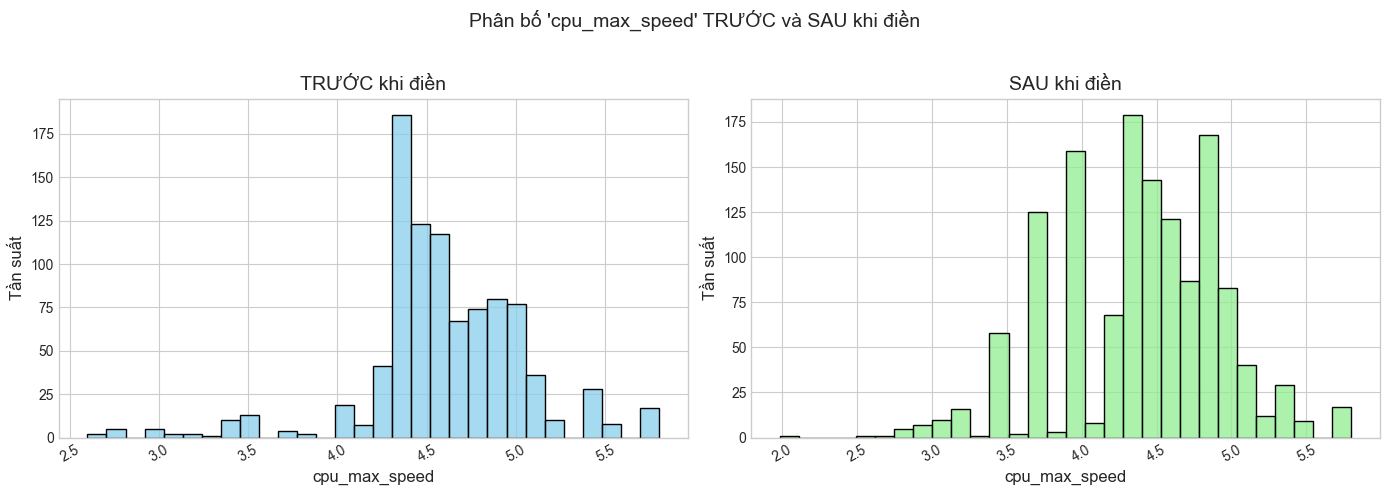

In [286]:
plot_distribution_with_labels(cpu_max_speed_before, df['cpu_max_speed'],'cpu_max_speed')

In [287]:
cpu_speed_before = df['cpu_speed'].copy()

In [288]:

def fill_cpu_speed(df: pd.DataFrame) -> pd.DataFrame:
    """
    Điền các giá trị còn thiếu trong cột 'cpu_speed' (base clock)
    bằng mô hình XGBoostRegressor, sử dụng các đặc trưng: cpu_model, cpu_series.
    """
    # 1. Tách dữ liệu không null và dữ liệu bị thiếu
    df_full = df.dropna(subset=['cpu_speed']).copy()
    df_missing = df[df['cpu_speed'].isna()].copy()
    
    features = ['cpu_model', 'cpu_series']
    X = df_full[features]
    y = df_full['cpu_speed']

    # 2. One-hot encoding cho biến phân loại
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['cpu_model', 'cpu_series'])
        ]
    )

    # 3. Pipeline kết hợp với mô hình XGBoost
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', xgb.XGBRegressor(random_state=42))
    ])

    # 4. GridSearchCV tìm siêu tham số tốt nhất
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.05, 0.1, 0.2],
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                               scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    print(f"✅ Best CV MAE: {-grid_search.best_score_:.3f}")
    print(f"✅ Best Hyperparameters: {grid_search.best_params_}")

    # 5. Đánh giá mô hình trên tập đầy đủ
    y_pred = cross_val_predict(best_model, X, y, cv=5, n_jobs=-1)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print("📊 Final Evaluation on non-null data:")
    print(f"➡️ MAE: {mae:.3f}")
    print(f"➡️ R² : {r2:.3f}")

    # 6. Dự đoán và điền giá trị thiếu nếu có
    if not df_missing.empty:
        X_missing = df_missing[features]
        df.loc[df['cpu_speed'].isna(), 'cpu_speed'] = best_model.predict(X_missing)
        print(f"✅ Filled {len(df_missing)} missing values in 'cpu_speed'.")
    else:
        print("ℹ️ No missing values in 'cpu_speed' to fill.")

    return df


In [289]:
df = fill_cpu_speed(df)


✅ Best CV MAE: 0.202
✅ Best Hyperparameters: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 7, 'regressor__n_estimators': 200}
📊 Final Evaluation on non-null data:
➡️ MAE: 0.202
➡️ R² : 0.808
✅ Filled 281 missing values in 'cpu_speed'.


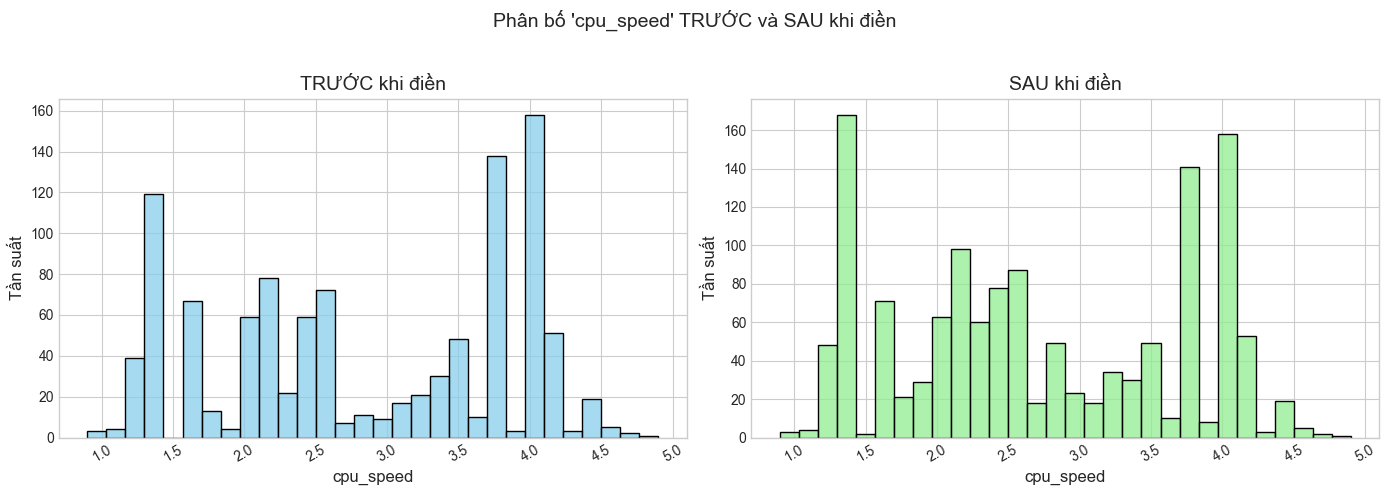

In [290]:
plot_distribution_with_labels(cpu_speed_before, df['cpu_speed'],'cpu_speed')

**1.10 refresh_rate**
- Rule-based cho các laptop hãng Apple
- Đặt các ngưỡng phù hợp cho các loại máy còn lại và dùng mode để fill các trường hợp đặc biệt


In [291]:
refresh_rate_before = df['refresh_rate'].copy()

In [ ]:
# Rule-based cho Apple
apple_refresh_rate_rules = {
    'm1': {'0.0': 60.0, '13.3': 60.0, '13.6': 60.0, '15.3': 60.0},
    'm1 pro': {'14.2': 120.0, '16.2': 120.0},
    'm1 max': {'0.0': 60.0, '14.2': 120.0, '16.2': 120.0},
    'm1 ultra': {'0.0': 60.0},
    'm2': {'0.0': 60.0, '13.6': 60.0, '15.3': 60.0},
    'm2 pro': {'0.0': 60.0, '14.2': 120.0, '16.2': 120.0},
    'm2 max': {'0.0': 60.0, '14.2': 120.0, '16.2': 120.0},
    'm2 ultra': {'0.0': 60.0},
    'm3': {'13.6': 60.0, '15.3': 60.0},
    'm3 pro': {'14.2': 120.0, '16.2': 120.0},
    'm3 max': {'14.2': 120.0, '16.2': 120.0},
    'm4': {'0.0': 60.0, '13.6': 60.0, '15.3': 60.0},
    'm4 pro': {'14.2': 120.0, '16.2': 120.0},
    'm4 max': {'0.0': 60.0, '14.2': 120.0, '16.2': 120.0},
    'm4 ultra': {'0.0': 60.0}
}


def impute_apple_refresh_rate(row):
    """
    Điền giá trị 'refresh_rate' còn thiếu cho các máy Apple dựa trên luật từ apple_refresh_rate_rules.

    Parameters:
        row (pd.Series): Một dòng dữ liệu.

    Returns:
        float: Tần số quét đã được điền hoặc giữ nguyên nếu không cần điền.
    """
    vga_brand = str(row.get("vga_brand", "")).lower()
    refresh_rate = row.get("refresh_rate")
    
    if vga_brand == "apple" and pd.isna(refresh_rate):
        cpu = str(row.get("cpu_series", "")).lower()
        size = str(row.get("display_size", "")).strip()
        
        if cpu in apple_refresh_rate_rules:
            return apple_refresh_rate_rules[cpu].get(size, 60.0)  # mặc định 60Hz nếu không khớp
    
        return 60.0  # fallback nếu không có luật
    
    return refresh_rate


In [ ]:
def fix_outliers(df):
    """Sửa các giá trị outlier cụ thể cho refresh_rate (ví dụ: 48Hz không hợp lý)."""
    df = df.copy()
    to_fix_60hz = [641, 1344, 1345]
    for idx in to_fix_60hz:
        if idx in df.index and df.loc[idx, "refresh_rate"] == 48.0:
            df.loc[idx, "refresh_rate"] = 60.0
    if 1339 in df.index and df.loc[1339, "refresh_rate"] == 48.0:
        df.loc[1339, "refresh_rate"] = 120.0
    return df


def adjust_mid_range(row):
    """Ưu tiên 120Hz cho laptop tầm trung có cấu hình phù hợp."""
    if (
        pd.isna(row["refresh_rate"])
        and row["vga_type"].lower() == "card tích hợp"
        and 8 <= row["cpu_cores"] <= 10
        and 12 <= row["cpu_threads"] <= 16
        and 15.6 <= row["display_size"] <= 16.1
    ):
        return 120.0
    return row["refresh_rate"]


def fix_nvidia_anomaly(row):
    """Fix trường hợp NVIDIA bị nhầm là card tích hợp với cấu hình cao."""
    if (
        str(row.get("vga_brand", "")).lower() == "nvidia"
        and row["vga_type"].lower() == "card tích hợp"
        and (
            row.get("display_size", 0) >= 15.6
            or row.get("cpu_cores", 0) >= 8
        )
    ):
        return 144.0
    return row["refresh_rate"]


def impute_non_apple_refresh_rate(df):
    """Điền giá trị missing trong 'refresh_rate' với nhiều tầng logic cho non-Apple."""
    df = fix_outliers(df.copy())

    # Bước 1: Mode theo vga_type, cpu_cores, cpu_threads
    df["refresh_rate"] = df.groupby(
        ["vga_type", "cpu_cores", "cpu_threads"]
    )["refresh_rate"].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

    # Bước 2: Mode theo vga_type, display_size
    df["refresh_rate"] = df.groupby(
        ["vga_type", "display_size"]
    )["refresh_rate"].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

    # Bước 3: Mode theo vga_type
    df["refresh_rate"] = df.groupby("vga_type")["refresh_rate"].transform(
        lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
    )

    # Bước 4: Ưu tiên 120Hz cho máy tầm trung
    df["refresh_rate"] = df.apply(adjust_mid_range, axis=1)

    # Bước 5: Sửa các bất thường do card NVIDIA
    df["refresh_rate"] = df.apply(fix_nvidia_anomaly, axis=1)

    # Bước 6: Gán mặc định còn thiếu là 60Hz
    df["refresh_rate"].fillna(60.0, inplace=True)

    return df


df = impute_non_apple_refresh_rate(df)

In [294]:
df[df['refresh_rate'] == 48]

,cam_ung,height_mm,url_path,material,storage_max_support,storage_gb,display_width,bluetooth_version,width_mm,manufacturer,cpu_max_speed,root_price,cpu_threads,cpu_cores,ram_speed,product_weight,discounted_price,ram_type,refresh_rate,cpu_speed,name,ram_storage,is_installment,ram_slots,os_version,battery_capacity,laptop_color,cpu_model,nhu_cau_su_dung,vga_type,depth_mm,image,vga_brand,product_id,cpu_series,display_height,vga_vram,laptop_camera,display_size,cpu_brand,hoc_tap_van_phong,laptop_sang_tao_noi_dung,mong_nhe,gaming,do_hoa_ky_thuat,cao_cap_sang_trong


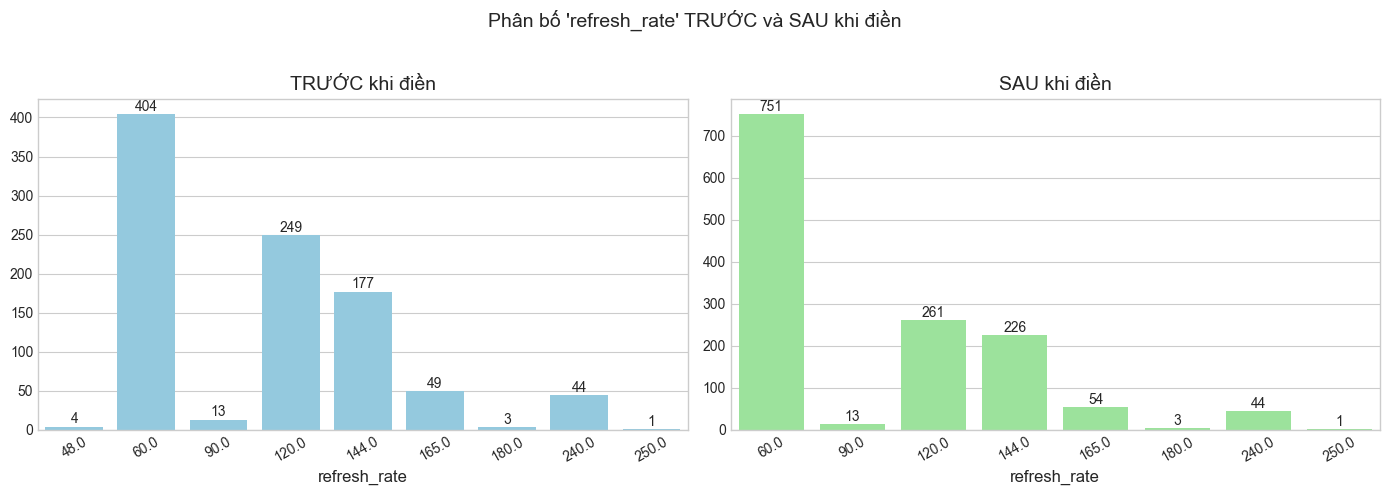

In [295]:
plot_distribution_with_labels(refresh_rate_before, df['refresh_rate'],'refresh_rate')

**1.11 battery_capacity**

Dùng median theo nhóm laptop khác nhau

In [296]:
battery_capacity_before = df['battery_capacity'].copy()

In [ ]:
def adjust_gaming_dohoa(row):
    """
    Nếu là laptop gaming hoặc đồ họa (card rời + có tag nhu cầu), 
    ưu tiên gán pin lớn hơn mặc định.
    """
    is_missing = pd.isna(row["battery_capacity"])
    is_discrete_gpu = row.get("vga_type", "").lower() == "card rời"
    is_gaming_or_dohoa = (
        "gaming" in str(row.get("nhu_cau_su_dung", "")).lower()
        or row.get("do_hoa_ky_thuat", 0) == 1
    )

    if is_missing and is_discrete_gpu and is_gaming_or_dohoa:
        return 75.0  # Giá trị điển hình cho laptop đồ họa/gaming

    return row["battery_capacity"]


def limit_lightweight(row):
    """
    Nếu laptop quá nhẹ (dưới 1.5kg) mà pin quá lớn, giới hạn lại cho hợp lý.
    """
    battery = row.get("battery_capacity", np.nan)
    weight = row.get("product_weight", np.nan)

    if pd.notna(battery) and battery > 80.0 and weight < 1.5:
        return 60.0  # Giới hạn pin vì lý do thực tế (pin lớn => máy nặng)
    return battery


def impute_battery_capacity(df):
    """
    Hàm điền khuyết giá trị 'battery_capacity' bằng nhiều cấp độ logic:
    median theo group, ưu tiên gaming, giới hạn máy mỏng nhẹ, fallback toàn bộ.
    """
    df = df.copy()

    # Bước 1: Median theo vga_type, display_size, cpu_cores
    df["battery_capacity"] = df.groupby(
        ["vga_type", "display_size", "cpu_cores"]
    )["battery_capacity"].transform(
        lambda x: x.fillna(x.median() if not x.isna().all() else np.nan)
    )

    # Bước 2: Median theo vga_type và display_size
    df["battery_capacity"] = df.groupby(
        ["vga_type", "display_size"]
    )["battery_capacity"].transform(
        lambda x: x.fillna(x.median() if not x.isna().all() else np.nan)
    )

    # Bước 3: Median theo vga_type
    df["battery_capacity"] = df.groupby("vga_type")["battery_capacity"].transform(
        lambda x: x.fillna(x.median() if not x.isna().all() else np.nan)
    )

    # Bước 4: Ưu tiên cho máy gaming/đồ họa
    df["battery_capacity"] = df.apply(adjust_gaming_dohoa, axis=1)

    # Bước 5: Giới hạn pin cho máy nhẹ
    df["battery_capacity"] = df.apply(limit_lightweight, axis=1)

    # Bước 6: Fallback toàn bộ cột
    df["battery_capacity"].fillna(df["battery_capacity"].median(), inplace=True)

    return df

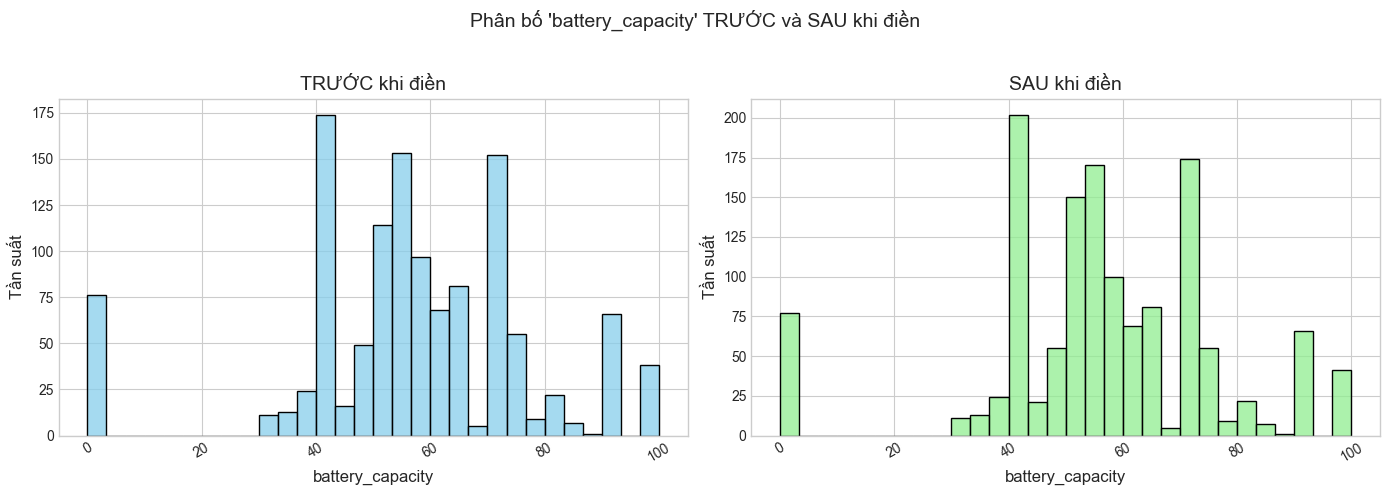

In [298]:
plot_distribution_with_labels(battery_capacity_before, df['battery_capacity'],'battery_capacity')

**1.12 ram_speed**

Điền theo median của ram_type

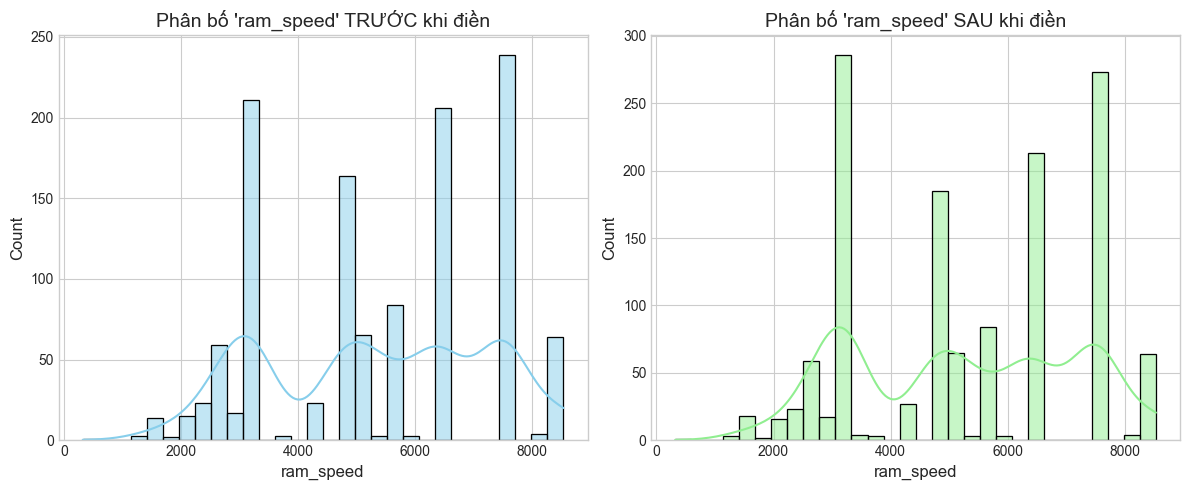

In [300]:
# 1. Lưu lại phân bố ban đầu (trước khi điền)
ram_speed_before = df['ram_speed'].copy()

# 2. Điền giá trị thiếu theo median của ram_type
median_by_type = df.groupby('ram_type')['ram_speed'].median()

def fill_median_ram_speed(row):
    if pd.isnull(row['ram_speed']) and row['ram_type'] in median_by_type:
        return median_by_type[row['ram_type']]
    return row['ram_speed']

df['ram_speed'] = df.apply(fill_median_ram_speed, axis=1)

# 3. Biểu đồ phân bố
plt.figure(figsize=(12, 5))

# Trước khi điền
plt.subplot(1, 2, 1)
sns.histplot(ram_speed_before, kde=True, bins=30, color='skyblue')
plt.title("Phân bố 'ram_speed' TRƯỚC khi điền")

# Sau khi điền
plt.subplot(1, 2, 2)
sns.histplot(df['ram_speed'], kde=True, bins=30, color='lightgreen')
plt.title("Phân bố 'ram_speed' SAU khi điền")

plt.tight_layout()
plt.show()


**1.13 vga_vram**

Điền theo nhóm các mục đích sử dụng bằng rule-based

In [301]:
vga_vram_before = df['vga_vram'].copy()

In [302]:
df.loc[df['vga_type'] == 'card tích hợp', 'vga_vram'] = 0.0

In [303]:
df_null_vga_vram = df[(df['vga_type'] == 'card rời') & (df['vga_vram'].isnull())]

In [304]:
df['vga_type'].value_counts()

vga_type
card tích hợp    968
card rời         385
Name: count, dtype: int64

In [306]:
df[df['vga_vram'].isna()].head()

,cam_ung,height_mm,url_path,material,storage_max_support,storage_gb,display_width,bluetooth_version,width_mm,manufacturer,cpu_max_speed,root_price,cpu_threads,cpu_cores,ram_speed,product_weight,discounted_price,ram_type,refresh_rate,cpu_speed,name,ram_storage,is_installment,ram_slots,os_version,battery_capacity,laptop_color,cpu_model,nhu_cau_su_dung,vga_type,depth_mm,image,vga_brand,product_id,cpu_series,display_height,vga_vram,laptop_camera,display_size,cpu_brand,hoc_tap_van_phong,laptop_sang_tao_noi_dung,mong_nhe,gaming,do_hoa_ky_thuat,cao_cap_sang_trong
556,0,213.9,https://cellphones.com.vn/laptop-asus-vivobook...,vỏ nhựa,512.0,512.0,1920.0,0.0,324.5,asus,4.30,14490000.0,8.0,4.0,6400.0,1.30,11630000.0,lpddr5,60.0,2.846189,Laptop Asus VivoBook Go 14 E1404FA-NK177W-Bạc,16.0,0,0.0,windows 11,42.0,bạc,7520u,"học tập - văn phòng, mỏng nhẹ",card rời,17.9,https://cdn2.cellphones.com.vn/insecure/rs:fil...,amd,64262.0,ryzen 5,1080.0,NaN,hd,14.0,amd,1,0,1,0,0,0
559,0,236.0,https://cellphones.com.vn/laptop-lenovo-ideapa...,vỏ kim loại,512.0,512.0,2560.0,5.3,339.3,lenovo,4.75,23490000.0,16.0,8.0,6400.0,1.49,21990000.0,lpddr5x,165.0,3.200000,Laptop Lenovo IdeaPad Slim 5 15ARP10 83J3002SV...,32.0,0,0.0,windows 11,70.0,xám,7735hs,"học tập - văn phòng, cao cấp - sang trọng, mỏn...",card rời,15.6,https://cdn2.cellphones.com.vn/insecure/rs:fil...,amd,100373.0,ryzen 7,1600.0,NaN,full hd,15.1,amd,1,0,1,0,0,1
595,0,225.5,https://cellphones.com.vn/laptop-acer-aspire-3...,vỏ nhựa,512.0,512.0,1920.0,5.1,318.2,acer,4.30,13990000.0,16.0,8.0,4266.0,1.40,11921000.0,lpddr4x,60.0,1.835177,Laptop Acer Aspire 3 A314-42P-R3B3 NX.KSFSV.00...,16.0,0,0.0,windows 11,50.0,bạc,5700u,"học tập - văn phòng, mỏng nhẹ",card rời,17.8,https://cdn2.cellphones.com.vn/insecure/rs:fil...,amd,75492.0,ryzen 7,1200.0,NaN,hd,14.0,amd,1,0,1,0,0,0
596,0,232.5,https://cellphones.com.vn/laptop-asus-vivobook...,vỏ nhựa,512.0,512.0,1920.0,0.0,360.3,asus,4.30,14490000.0,8.0,4.0,6400.0,1.80,11921000.0,lpddr5,60.0,2.846189,Laptop Asus Vivobook GO 15 E1504FA-NJ454W-Bạc,16.0,0,0.0,windows 11,42.0,bạc,7520u,học tập - văn phòng,card rời,17.9,https://cdn2.cellphones.com.vn/insecure/rs:fil...,amd,72680.0,ryzen 5,1080.0,NaN,hd,15.6,amd,1,0,0,0,0,0
597,0,251.0,https://cellphones.com.vn/laptop-asus-tuf-gami...,vỏ nhựa,512.0,512.0,1920.0,5.2,354.0,asus,4.90,28990000.0,16.0,10.0,4800.0,2.20,25590000.0,ddr5,144.0,2.400000,Laptop Asus TUF Gaming F15 FX507VU-LP198W-Xám,16.0,0,2.0,windows 11,90.0,xám,13620h,gaming,card rời,22.4,https://cdn2.cellphones.com.vn/insecure/rs:fil...,nvidia,75941.0,core i7,1080.0,NaN,hd,15.6,intel,0,0,0,1,0,0


In [ ]:
def guess_vram(row):
    """
    Dự đoán dung lượng VRAM (bộ nhớ đồ họa) của laptop dựa trên các thông tin phần cứng.

    Parameters:
    ----------
    row : pd.Series
        Một dòng dữ liệu chứa các thông tin như CPU, VGA, RAM và mục đích sử dụng.

    Returns:
    -------
    float or int
        Dung lượng VRAM ước lượng (theo GB). Trả về giá trị mặc định nếu không đủ thông tin.
    """
    cpu = str(row.get("cpu_model", "")).lower()
    series = str(row.get("cpu_series", "")).lower()
    ram = row.get("ram_storage", 0)
    vga_brand = str(row.get("vga_brand", "")).lower()
    vga_type = str(row.get("vga_type", "")).lower()

    is_gaming = row.get("gaming", 0)
    is_creative = row.get("laptop_sang_tao_noi_dung", 0)
    is_office = row.get("hoc_tap_van_phong", 0)
    is_graphics = row.get("do_hoa_ky_thuat", 0)
    is_high_end = row.get("cao_cap_sang_trong", 0)

    # --- Ưu tiên logic theo card đồ họa ---
    if "nvidia" in vga_brand:
        if any(x in cpu for x in ["rtx 4050", "rtx 4060", "rtx 4070"]):
            return 6
        elif "rtx 3050" in cpu:
            return 6
        elif "gtx" in cpu:
            return 4
        elif "mx" in cpu:
            return 2
        else:
            return 4 if is_gaming or is_graphics else 2

    if "amd" in vga_brand:
        if "rx" in cpu:
            return 4
        elif "680m" in cpu or "780m" in cpu:
            return 2
        elif "radeon" in cpu:
            return 1.5 if ram >= 8 else 1
        else:
            return 1

    if "intel" in vga_brand:
        if "iris" in cpu:
            return 1.5 if ram >= 8 else 1
        else:
            return 0.5

    # --- Fallback theo mục đích sử dụng ---
    if is_gaming or is_graphics:
        return 4
    elif is_creative:
        return 3
    elif is_high_end:
        return 2
    elif is_office:
        return 1
    else:
        if ram >= 32:
            return 6
        elif ram >= 16:
            return 4
        elif ram >= 8:
            return 2
        else:
            return 1

In [308]:

mask = df['vga_vram'].isna() 
df.loc[mask, 'vga_vram'] = df.loc[mask].apply(guess_vram, axis=1)


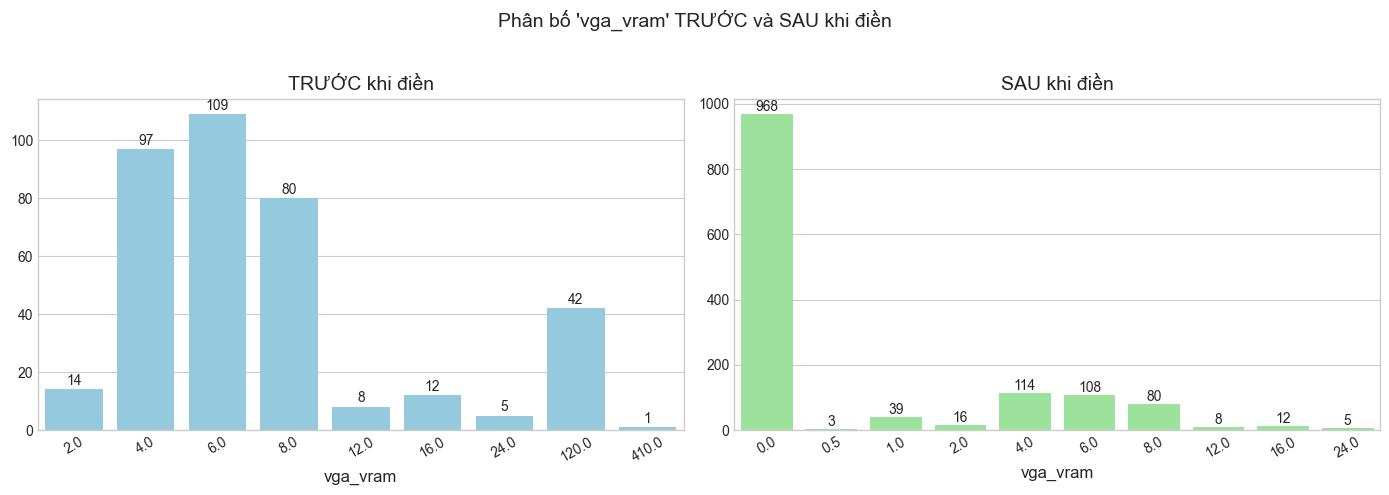

In [309]:
plot_distribution_with_labels(vga_vram_before, df['vga_vram'],'vga_vram')

**1.14 discounted_price và root_price**

Điền theo mean và fill mannual vài laptop

In [310]:
# 1. Nếu url_path chứa "thegioididong" → gán root_price = discounted_price
mask_tgdd = df['url_path'].str.contains('thegioididong', case=False, na=False)
df.loc[mask_tgdd & df['discounted_price'].notna(), 'root_price'] = df.loc[mask_tgdd & df['discounted_price'].notna(), 'discounted_price']

# 2. Tính phần trăm giảm giá trung bình từ các dòng hợp lệ
valid = df[df['root_price'].notna() & df['discounted_price'].notna()]
avg_discount = ((valid['root_price'] - valid['discounted_price']) / valid['root_price']).mean()

# 3. Fill các discounted_price bị thiếu dựa vào root_price và phần trăm giảm
mask_fill_discount = df['discounted_price'].isna() & df['root_price'].notna()
df.loc[mask_fill_discount, 'discounted_price'] = df.loc[mask_fill_discount, 'root_price'] * (1 - avg_discount)

# (Tuỳ chọn) Làm tròn giá
df['discounted_price'] = df['discounted_price'].round(0)

In [311]:
df[(df['root_price'].isna()) & (df['discounted_price'].notna())]

,cam_ung,height_mm,url_path,material,storage_max_support,storage_gb,display_width,bluetooth_version,width_mm,manufacturer,cpu_max_speed,root_price,cpu_threads,cpu_cores,ram_speed,product_weight,discounted_price,ram_type,refresh_rate,cpu_speed,name,ram_storage,is_installment,ram_slots,os_version,battery_capacity,laptop_color,cpu_model,nhu_cau_su_dung,vga_type,depth_mm,image,vga_brand,product_id,cpu_series,display_height,vga_vram,laptop_camera,display_size,cpu_brand,hoc_tap_van_phong,laptop_sang_tao_noi_dung,mong_nhe,gaming,do_hoa_ky_thuat,cao_cap_sang_trong
1098,0,243.0,https://cellphones.com.vn/laptop-asus-zenbook-...,vỏ kim loại,1024.0,1024.0,2880.0,5.4,353.6,asus,5.000000,NaN,16.0,8.0,7500.0,1.50,39490000.0,lpddr5x,120.0,2.000000,Laptop ASUS Zenbook S 16 UM5606KA-RK127WS-Trắng,24.0,0,0.0,windows 11,78.0,trắng,350,"học tập - văn phòng, cao cấp - sang trọng, lap...",card rời,11.9,https://cdn2.cellphones.com.vn/insecure/rs:fil...,amd,102625.0,ryzen ai 7,1800.0,1.0,full hd,16.0,amd,1,1,0,0,0,1
1102,0,461.0,https://cellphones.com.vn/imac-m3-2023-24-inch...,vỏ kim loại,512.0,512.0,4480.0,5.3,547.0,apple,3.700000,NaN,12.0,8.0,6400.0,4.48,51990000.0,lpddr5,60.0,3.700000,iMac M3 24 inch 16GB 512GB | Chính hãng Apple ...,16.0,0,0.0,macos,0.0,hồng,m3,"học tập - văn phòng, đồ họa - kỹ thuật, cao cấ...",card tích hợp,147.0,https://cdn2.cellphones.com.vn/insecure/rs:fil...,apple,84242.0,m3,2520.0,0.0,full hd,24.0,apple,1,0,0,0,1,1
1103,0,461.0,https://cellphones.com.vn/imac-m3-2023-24-inch...,vỏ kim loại,512.0,512.0,4480.0,5.3,547.0,apple,3.700000,NaN,12.0,8.0,6400.0,4.48,51990000.0,lpddr5,60.0,3.700000,iMac M3 24 inch 16GB 512GB | Chính hãng Apple ...,16.0,0,0.0,macos,0.0,bạc,m3,"học tập - văn phòng, đồ họa - kỹ thuật, cao cấ...",card tích hợp,147.0,https://cdn2.cellphones.com.vn/insecure/rs:fil...,apple,84243.0,m3,2520.0,0.0,full hd,24.0,apple,1,0,0,0,1,1
1273,0,254.4,https://cellphones.com.vn/laptop-msi-prestige-...,vỏ kim loại,1024.0,1024.0,3840.0,5.4,358.4,msi,5.072349,NaN,7.0,6.0,8533.0,1.50,43990000.0,lpddr5x,60.0,3.187308,Laptop MSI Prestige 16 AI+ Evo B2VMG-016VN-Xám,32.0,0,0.0,windows 11,99.9,xám,288v,"học tập - văn phòng, cao cấp - sang trọng",card tích hợp,16.9,https://cdn2.cellphones.com.vn/insecure/rs:fil...,intel,96710.0,core ultra 9,2400.0,0.0,full hd,16.0,intel,1,0,0,0,0,1
1274,0,210.0,https://cellphones.com.vn/laptop-msi-prestige-...,vỏ kim loại,1024.0,1024.0,2880.0,5.4,299.0,msi,4.789609,NaN,8.0,8.0,8533.0,0.99,35690000.0,lpddr5x,60.0,2.265349,Laptop MSI Prestige 13 AI+ Evo A2VMG-040VN-Xám,32.0,0,0.0,windows 11,75.0,xám,258v,"học tập - văn phòng, mỏng nhẹ",card tích hợp,16.9,https://cdn2.cellphones.com.vn/insecure/rs:fil...,intel,96717.0,core ultra 7,1800.0,0.0,full hd,13.3,intel,1,0,1,0,0,0


In [312]:
df.loc[1098, 'root_price'] = 42990000.0
df.loc[1102, 'root_price'] = 51990000.0
df.loc[1103, 'root_price'] = 51990000.0
df.loc[1273, 'root_price'] = 45990000.0
df.loc[1274, 'root_price'] = 38990000.0

In [313]:
df['root_price'] = df['root_price'].replace(0, np.nan)  
df['discounted_price'] = df['discounted_price'].replace(0, np.nan)  

In [314]:
detect_missing(df)

,Missing Values,Missing %
root_price,277,20.473023
discounted_price,277,20.473023


In [ ]:
df = df.drop(columns='nhu_cau_su_dung')

In [316]:
df_train =  df.dropna()

In [317]:
df_train.to_csv('laptop_cleaned.csv', index=False)

In [ ]:
df_test = df[df.isnull().any(axis=1)]

In [ ]:
detect_missing(df_test)

,Missing Values,Missing %
root_price,277,100.0
discounted_price,277,100.0


In [ ]:
df_test.to_csv('laptop_null_price.csv', index=False)

In [ ]:
df.to_csv('laptop_merge_v4.csv', index=False)